# 第3章

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

### CSVファイルを読みこむ

In [2]:
# CSVファイルを読みこむ
dau = pd.read_csv("../Data/section3-dau.csv")
dau.head()

,log_date,app_name,user_id
0,2013-06-01,game-01,116
1,2013-06-01,game-01,13491
2,2013-06-01,game-01,7006
3,2013-06-01,game-01,117
4,2013-06-01,game-01,13492


In [3]:
dpu = pd.read_csv("../Data/section3-dpu.csv")
dpu.head()

,log_date,app_name,user_id,payment
0,2013-06-01,game-01,351,1333
1,2013-06-01,game-01,12796,81
2,2013-06-01,game-01,364,571
3,2013-06-01,game-01,13212,648
4,2013-06-01,game-01,13212,1142


In [4]:
install = pd.read_csv("../Data/section3-install.csv")
install.head()

,install_date,app_name,user_id
0,2013-04-15,game-01,1
1,2013-04-15,game-01,2
2,2013-04-15,game-01,3
3,2013-04-15,game-01,4
4,2013-04-15,game-01,5


### DAUのデータにInstallデータをくっつける

In [5]:
dau_install = pd.merge(dau, install, on = ["user_id", "app_name"], how = "outer")
dau_install.head()

,log_date,app_name,user_id,install_date
0,2013-06-01,game-01,116,2013-04-17
1,2013-06-02,game-01,116,2013-04-17
2,2013-06-03,game-01,116,2013-04-17
3,2013-06-04,game-01,116,2013-04-17
4,2013-06-05,game-01,116,2013-04-17


### 上記のデータに、さらにDPUデータをくっつける

In [6]:
dau_install_payment = pd.merge(dau_install, dpu, on = ["log_date", "app_name", "user_id"], how = "left")
dau_install_payment.head()

,log_date,app_name,user_id,install_date,payment
0,2013-06-01,game-01,116,2013-04-17,NaN
1,2013-06-02,game-01,116,2013-04-17,NaN
2,2013-06-03,game-01,116,2013-04-17,NaN
3,2013-06-04,game-01,116,2013-04-17,NaN
4,2013-06-05,game-01,116,2013-04-17,NaN


In [7]:
dau_install_payment.dropna().head()

,log_date,app_name,user_id,install_date,payment
86,2013-06-02,game-01,117,2013-04-17,1333.0
87,2013-06-02,game-01,117,2013-04-17,571.0
95,2013-06-10,game-01,117,2013-04-17,952.0
96,2013-06-11,game-01,117,2013-04-17,1333.0
97,2013-06-11,game-01,117,2013-04-17,571.0


### 非課金ユーザの課金額にゼロをいれる

In [8]:
# 非課金のレコードの課金額を0にする
dau_install_payment = dau_install_payment.fillna({"payment": 0})
dau_install_payment.head()

,log_date,app_name,user_id,install_date,payment
0,2013-06-01,game-01,116,2013-04-17,0.0
1,2013-06-02,game-01,116,2013-04-17,0.0
2,2013-06-03,game-01,116,2013-04-17,0.0
3,2013-06-04,game-01,116,2013-04-17,0.0
4,2013-06-05,game-01,116,2013-04-17,0.0


### 月次で集計する

In [9]:
# 月のカラム追加
dau_install_payment["log_month"] = dau_install_payment["log_date"].str.slice(0, 7)
dau_install_payment["install_month"] = dau_install_payment["install_date"].str.slice(0, 7)

mau_payment = dau_install_payment.groupby(["log_month", "user_id", "install_month"]).sum().reset_index()

mau_payment.head()

,log_month,user_id,install_month,payment
0,2013-06,1,2013-04,0.0
1,2013-06,2,2013-04,0.0
2,2013-06,3,2013-04,14994.0
3,2013-06,4,2013-04,0.0
4,2013-06,6,2013-04,0.0


### 新規ユーザか既存ユーザかの区分を追加する

In [10]:
# 新規ユーザと既存ユーザの識別
mau_payment["user_type"] = np.where(mau_payment["install_month"] == mau_payment["log_month"], "install", "existing")
mau_payment.head()

,log_month,user_id,install_month,payment,user_type
0,2013-06,1,2013-04,0.0,existing
1,2013-06,2,2013-04,0.0,existing
2,2013-06,3,2013-04,14994.0,existing
3,2013-06,4,2013-04,0.0,existing
4,2013-06,6,2013-04,0.0,existing


In [11]:
mau_payment_summary = mau_payment.groupby(["log_month", "user_type"]).sum().reset_index()
mau_payment_summary.head()

,log_month,user_type,user_id,payment
0,2013-06,existing,43563016,177886.0
1,2013-06,install,166636855,49837.0
2,2013-07,existing,72119293,177886.0
3,2013-07,install,172505465,29199.0


### グラフによりデータを可視化する

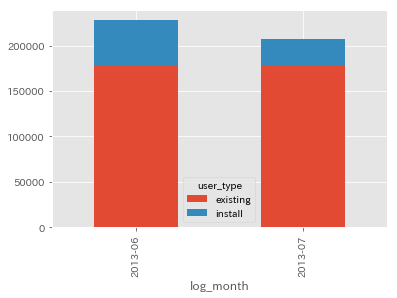

In [12]:
mau_payment_summary.pivot("log_month", "user_type").plot(kind = "bar", y= "payment", stacked = True)

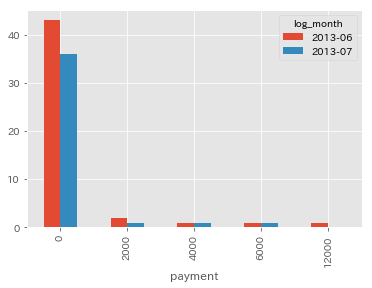

In [13]:
mau_payment["payment_band"] = mau_payment["payment"].apply(lambda x: int(int(x) / 2000) * 2000)
mau_payment.query("payment > 0 & user_type == 'install'").groupby(["payment_band", "log_month"])["user_id"].count().unstack().fillna(0).plot(kind = "bar")
plt.xlabel("payment")